# Face Recognition -Model7

使用MTCNN進行人臉偵測

使用自建CNN模型進行人臉辨識

使用kaggle5位日本明星資料集

進行靜態圖像辨識
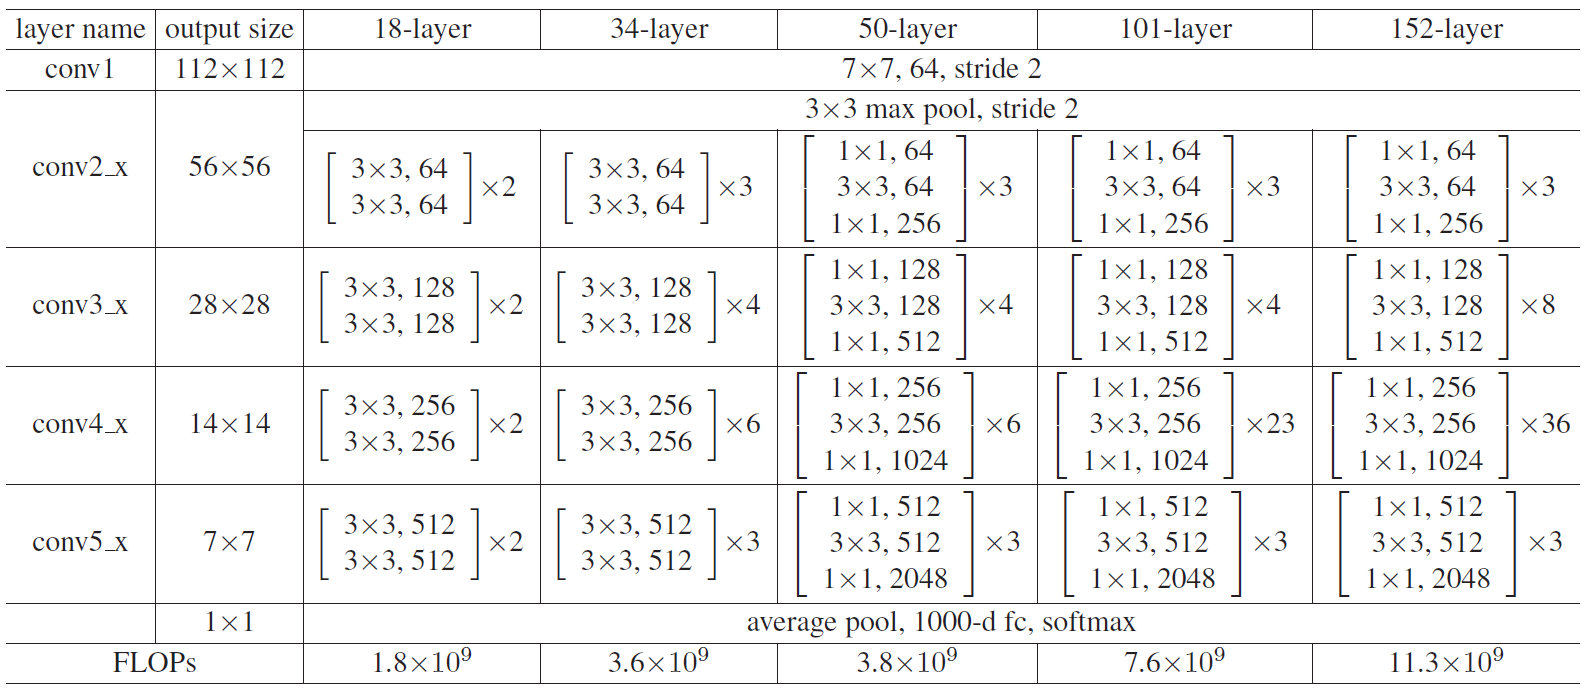

In [1]:
from __future__ import division

# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

#Utilities相關函式庫
import os
import sys

# Python2.X和3.X相容
import six

# 圖像處理函示庫
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 數值處理函式庫
import pandas as pd
import numpy as np

# 機器學習函式庫
from sklearn.model_selection import train_test_split

# 深度學習函式庫
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Convolution2D, Dropout, Flatten, merge, Reshape, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, add, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import np_utils
from keras import regularizers
from keras import initializers
from keras.regularizers import l2
from keras import initializers
from keras.engine import Layer, InputSpec, get_source_inputs
import tensorflow as tf


# Backend
from keras import backend as K

# 人臉偵測函式庫
from mtcnn import MTCNN
detector = MTCNN()

# 相關參數設定
picture_size = 224
batch_size = 8  # 一次用多少筆資料更新模型
num_classes = 5  # 資料集有幾個類別
epochs = 300      # 訓練迭代次數
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model7_Resnet_V1, trained_model.h5' # 模型名稱


Using TensorFlow backend.


In [2]:
# 直接讀取處理好的檔案
total_img_resized = np.load('total_crop_resized.npy')
labelnames = np.load('labelnames.npy')
total_img_resized.shape

(448, 224, 224, 3)

In [3]:
# 切分訓練/測試資料
#train_x = total_img
#train_y = labelnames

train_x,test_x, train_y, test_y = train_test_split(total_img_resized,
                                                  labelnames,
                                                test_size = 0.1,stratify= labelnames)#random_state = 123,
print('train:',train_x.shape,'test:',test_x.shape)

# 正規化資料
# 標準化0~255的值到0~1
x_train_normalize = train_x.astype('float32') / 255.0
x_test_normalize = test_x.astype('float32') / 255.0

train: (403, 224, 224, 3) test: (45, 224, 224, 3)


In [5]:
# ResNet34
#Define convolution with batchnromalization
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x
  
#Define Residual Block for ResNet34(2 convolution layers)
def Residual_Block(input_model,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut =False):
    x = Conv2d_BN(input_model,nb_filter=nb_filter,kernel_size=kernel_size,strides=strides,padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size,padding='same')
    
    #need convolution on shortcut for add different channel
    if with_conv_shortcut:
        shortcut = Conv2d_BN(input_model,nb_filter=nb_filter,strides=strides,kernel_size=kernel_size)
        x = add([x,shortcut])
        return x
    else:
        x = add([x,input_model])
        return x
    
#Built ResNet34
def ResNet34(width, height, depth, classes):
    
    Img = Input(shape=(width,height,depth))
    
    x = Conv2d_BN(Img,64,(7,7),strides=(2,2),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)  

    #Residual conv2_x ouput 56x56x64 
    x = Residual_Block(x,nb_filter=64,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=64,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=64,kernel_size=(3,3))
    
    #Residual conv3_x ouput 28x28x128 
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)# need do convolution to add different channel
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3))
    
    #Residual conv4_x ouput 14x14x256
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)# need do convolution to add different channel
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    
    #Residual conv5_x ouput 7x7x512
    x = Residual_Block(x,nb_filter=512,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
    x = Residual_Block(x,nb_filter=512,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=512,kernel_size=(3,3))


    #Using AveragePooling replace flatten
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes,activation='softmax')(x)
    
    model=Model(input=Img,output=x)
    return model 

model = ResNet34(224, 224, 3, 5)
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_14

In [39]:
# ResNet34/50
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x


def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def resnet_34(width,height,channel,classes):
    inpt = Input(shape=(width, height, channel))
    x = ZeroPadding2D((3, 3))(inpt)

    #conv1
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #conv2_x
    x = identity_Block(x, nb_filter=64, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=64, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=64, kernel_size=(3, 3))

    #conv3_x
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3))

    #conv4_x
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))

    #conv5_x
    x = identity_Block(x, nb_filter=512, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = identity_Block(x, nb_filter=512, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=512, kernel_size=(3, 3))
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inpt, outputs=x)
    return model

def resnet_50(width,height,channel,classes):
    inpt = Input(shape=(width, height, channel))
    x = ZeroPadding2D((3, 3))(inpt)
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #conv2_x
    x = bottleneck_Block(x, nb_filters=[64,64,256],strides=(1,1),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[64,64,256])
    x = bottleneck_Block(x, nb_filters=[64,64,256])

    #conv3_x
    x = bottleneck_Block(x, nb_filters=[128, 128, 512],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])

    #conv4_x
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    

    #conv5_x
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048], strides=(2, 2), with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])

    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inpt, outputs=x)
    return model
model = resnet_50(224, 224, 3, 5)

In [41]:
# ResNet101
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x


def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def resnet_101(width,height,channel,classes):
    inpt = Input(shape=(width, height, channel))
    x = ZeroPadding2D((3, 3))(inpt)
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #conv2_x
    x = bottleneck_Block(x, nb_filters=[64,64,256],strides=(1,1),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[64,64,256])
    x = bottleneck_Block(x, nb_filters=[64,64,256])

    #conv3_x
    x = bottleneck_Block(x, nb_filters=[128, 128, 512],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])

    #conv4_x
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])

    #conv5_x
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048], strides=(2, 2), with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])

    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inpt, outputs=x)
    return model
model = resnet_101(224, 224, 3, 5)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_768 (Conv2D)             (None, 112, 112, 64) 9472        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
batch_normalization_742 (BatchN (None, 112, 112, 64) 256         conv2d_768[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [71]:
# 訓練模型
# optimizer = Adam(lr=1e-4,decay=0.0001,beta_1=0.99,beta_2=0.999) #100e-6
sgd = keras.optimizers.SGD(lr=1e-6, momentum=0.9, decay=1e-5, nesterov=True)
model.compile(loss = 'categorical_crossentropy',
             optimizer = sgd,
             metrics = ['accuracy'])

In [72]:
# Data Augmentation
datagen  = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True, 
            vertical_flip = False,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

In [73]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

# Fit model
aug_ratio = 2
steps_per_epoch = int(aug_ratio * train_x.shape[0] / batch_size)
validation_steps = int(aug_ratio * test_x.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(x_train_normalize, train_y, batch_size = batch_size),
                                   epochs = epochs,
                                   validation_data = (x_test_normalize, test_y),
                                   callbacks = [checkpoint, earlystop],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=validation_steps
                                   )

Epoch 1/300
100/100 [==============================] - 50s 503ms/step - loss: 0.2048 - acc: 0.9275 - val_loss: 1.1999 - val_acc: 0.6889

Epoch 00001: val_loss improved from inf to 1.19988, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model7_Resnet_V1, trained_model.h5
Epoch 2/300
100/100 [==============================] - 12s 119ms/step - loss: 0.2189 - acc: 0.9326 - val_loss: 1.1788 - val_acc: 0.7333

Epoch 00002: val_loss improved from 1.19988 to 1.17882, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model7_Resnet_V1, trained_model.h5
Epoch 3/300
100/100 [==============================] - 12s 119ms/step - loss: 0.1799 - acc: 0.9487 - val_loss: 1.1942 - val_acc: 0.7111

Epoch 00003: val_loss did not improve from 1.17882
Epoch 4/300
100/100 [==============================] - 12s 119ms/step - loss: 0.1835 - acc: 0.9400 - val_loss: 1.1914 - val_acc: 0.6889

Epoch 00004: val_loss did not improve from 1.17882
Epoch 5/300
100/100 


Epoch 00039: val_loss did not improve from 1.14891
Epoch 40/300
100/100 [==============================] - 12s 120ms/step - loss: 0.2080 - acc: 0.9262 - val_loss: 1.1387 - val_acc: 0.7333

Epoch 00040: val_loss improved from 1.14891 to 1.13875, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model7_Resnet_V1, trained_model.h5
Epoch 41/300
100/100 [==============================] - 12s 119ms/step - loss: 0.2061 - acc: 0.9317 - val_loss: 1.1547 - val_acc: 0.7111

Epoch 00041: val_loss did not improve from 1.13875
Epoch 42/300
100/100 [==============================] - 12s 120ms/step - loss: 0.1937 - acc: 0.9442 - val_loss: 1.1270 - val_acc: 0.7111

Epoch 00042: val_loss improved from 1.13875 to 1.12704, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model7_Resnet_V1, trained_model.h5
Epoch 43/300
100/100 [==============================] - 12s 119ms/step - loss: 0.2453 - acc: 0.9196 - val_loss: 1.1476 - val_acc: 0.6889

Epoch 00043

In [ ]:
# loading save model
print('Loading trained model')
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test_normalize, test_y, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()